# Modelling a neural network
The point of this session is to become familiar with Keras and start doing some experiments

In [1]:
import numpy as np
# import pipeline as io
import keras
import matplotlib.pyplot as plt
%matplotlib inline

from google.colab import drive
drive.mount('/content/gdrive')

Using TensorFlow backend.


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
!pip install fitsio

    100% |████████████████████████████████| 4.8MB 1.2MB/s 
  Running setup.py bdist_wheel for fitsio ... - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / done
  Stored in directory: /root/.cache/pip/wheels/a1/de/35/ca1372d3267a2293bb079a444f3899c1cce0cac5c0191c8906
Successfully built fitsio


In [0]:
import sys
sys.path.append('/content/gdrive/My Drive/mqc-collab/')
import pipeline as io

----
Check on how to save the dataset to a HDF5 file 

In [0]:
import h5py
import os


from keras.layers import Input, Dense, Conv1D, Dropout, Flatten
from keras.activations import  softmax, relu, sigmoid
from keras.models import Model, Sequential
from keras.utils import to_categorical

from sklearn.model_selection import train_test_split


def performance_plots(filename, sgdparams, histobject, testmetrics):
    
    loss = histobject.history['loss']
    val_loss = histobject.history['val_loss']
    binary_accuracy = histobject.history['binary_accuracy']
    val_binary_accuracy = histobject.history['val_binary_accuracy']
    
    plt.style.use('default')
    fig, ax = plt.subplots(nrows=2, ncols=2, sharex=True,
                          sharey='row', figsize=(9,9))
    ax[0,0].plot(loss)
    ax[0,0].set_ylabel(r'Categorical cross-entropy loss')
    ax[0,1].plot(val_loss)
    ax[0,1].set_ylabel(r'Loss on validation data')
    ax[1,0].plot(binary_accuracy)
    ax[1,0].set_ylabel(r'Binary accuracy on training data')
    ax[1,1].plot(val_binary_accuracy)
    ax[1,1].set_ylabel(r'Binary accuracy on validation data')
    
    ax[1,0].set_xlabel(r'Epoch')
    ax[1,1].set_xlabel(r'Epoch')
    
    metadata = histobject.params
    metadata['test_metrics'] = testmetrics
    metadata['sgd_params'] = sgdparams
    
    i = 0
    while os.path.exists('{}{:d}.png'.format(filename, i)):
      i += 1
    
    plt.savefig('{}{:d}.png'.format(filename, i), dpi=450, metadata=metadata)
    
    model_filename = '{}{:d}.h5'.format(filename, i)
    return model_filename
   

with h5py.File('/content/gdrive/My Drive/mqc-collab/dataset2K_433t.h5', 'r') as sb:
    og_shape = sb['fluxes'].shape
    data = np.array(sb['fluxes']).reshape((*og_shape, 1))
    labels = to_categorical(np.array(sb['classes']))
    
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.20,
                                                       random_state=42)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.50,
                                                   random_state=42)

200/200 [==============================] - 0s 114us/step
test_loss: 0.2829028844833374
binary_accuracy: 0.9
CPU times: user 2min 45s, sys: 46.1 s, total: 3min 31s
Wall time: 3min 20s


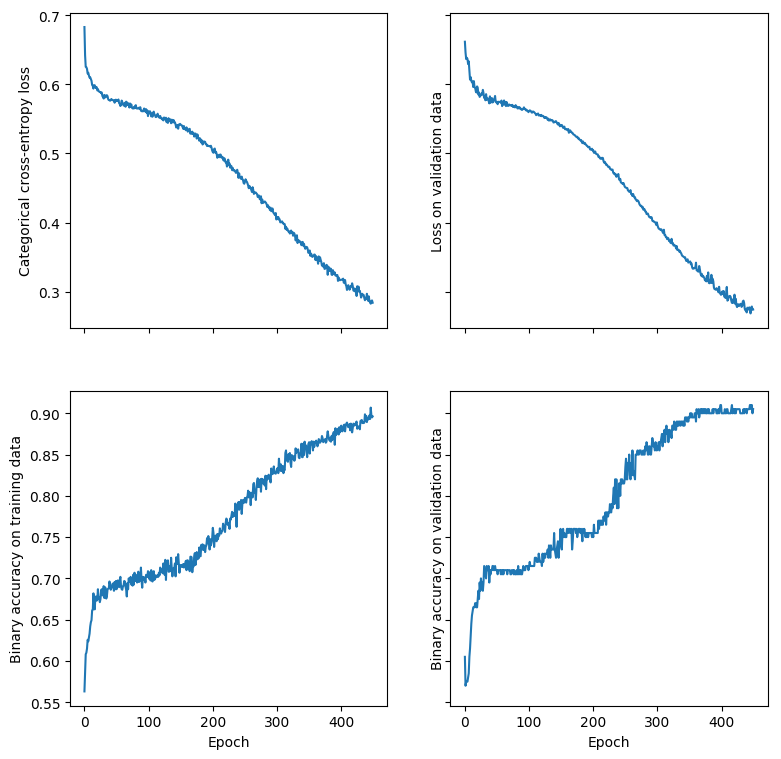

In [0]:
%%time

sgdparams = {'lr':0.01, 'momentum':0.9, 'nesterov':True, 'decay':0.01}
    
    
model = Sequential()
model.add(Conv1D(filters=100, kernel_size=10,
                 strides=2, activation='relu',
                input_shape=(433,1)))

model.add(Conv1D(filters=100, kernel_size=10, 
                 strides=2, activation='relu'))
model.add(Conv1D(filters=100, kernel_size=10,
                 strides=2, activation='relu'))
model.add(Conv1D(filters=100, kernel_size=10,
                 strides=2, activation='relu'))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.SGD(**sgdparams),
             metrics=['binary_accuracy'])
training = model.fit(x_train, y_train, epochs=450, batch_size=40, 
                     validation_data=(x_val, y_val), verbose=0)
metrics = model.evaluate(x_test, y_test, batch_size=40)

model_filename = performance_plots('/content/gdrive/My Drive/mqc-collab/plots/model4_run', sgdparams,training, metrics)
print('test_loss: {}\nbinary_accuracy: {}'.format(metrics[0], metrics[1]))
model.save(model_filename)

This is a good model., however it may not be an improvement over the first one I trained. Run 0 gave 93% accuracy but then,
Run 1 only 90%. 

 Now let's use a bigger dataset, 17749 stars and 17750 quasars. The stellar spectra were selected in order to have the most homogeneous sample possible. We randomly chose 1775 objects from each of the following spectral types: O, B, A, F, G, K, M, L,  Carbon Stars and White Dwarfs.
 

In [0]:
# Load the new dataset
with h5py.File('/content/gdrive/My Drive/mqc-collab/dataset35499_433t.h5', 'r') as sb:
    og_shape = sb['fluxes'].shape
    data = np.array(sb['fluxes']).reshape((*og_shape, 1))
    labels = to_categorical(np.array(sb['classes']))
    
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.20,
                                                       random_state=42)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.50,
                                                   random_state=42)

In [0]:
%%time

sgdparams = {'lr':0.5, 'momentum':0.9, 'nesterov':True, 'decay':0.01}
    
    
model = Sequential()
model.add(Conv1D(filters=100, kernel_size=7,
                 strides=1, activation='relu',
                input_shape=(433,1)))
model.add(Conv1D(filters=100, kernel_size=9, 
                 strides=1, activation='relu'))
model.add(Conv1D(filters=100, kernel_size=11,
                 strides=1, activation='relu'))
model.add(Conv1D(filters=100, kernel_size=13,
                 strides=1, activation='relu'))
model.add(Conv1D(filters=100,kernel_size=15,
                 strides=3, activation='relu'))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.SGD(**sgdparams),
             metrics=['binary_accuracy'])
training = model.fit(x_train, y_train, epochs=25, batch_size=100, 
                     validation_data=(x_val, y_val), verbose=1)
metrics = model.evaluate(x_test, y_test, batch_size=40)

model_filename = performance_plots('/content/gdrive/My Drive/mqc-collab/plots/model6_run', sgdparams,training, metrics)
print('test_loss: {}\nbinary_accuracy: {}'.format(metrics[0], metrics[1]))
model.save(model_filename)

Train on 28400 samples, validate on 3550 samples
Epoch 1/25
28400/28400 [==============================] - 22s 761us/step - loss: 0.6960 - binary_accuracy: 0.4968 - val_loss: 0.6931 - val_binary_accuracy: 0.5031
Epoch 2/25
28400/28400 [==============================] - 19s 682us/step - loss: 0.6941 - binary_accuracy: 0.4959 - val_loss: 0.6944 - val_binary_accuracy: 0.4969
Epoch 3/25
17700/28400 [=================>............] - ETA: 7s - loss: 0.6938 - binary_accuracy: 0.4958

KeyboardInterrupt: ignored

I expected that using a bigger dataset (35K spectra versus 2K), would immediately yield better results with the same architecture. After fiddling with the model and its parameters in Collab I was pretty disappointed because I cannot get the model to learn anything. It is stuck on loss ~0.6. Also the binary accuracy on the validation set is 0.4969 at the end of almost every epoch. Need to 1) tune those hyperparameters and/or 2) keep trying new architectures (deeper or shallower) 